In [1]:
import pandas as pd
import os
import json
import numpy as np



In [2]:
headers=["sentence_id", "sentence", "phrase_start", "phrase_end", 'phrase', 'num_native_annotator', "num_non_native_annotator", "num_complex_marks_native", "num_complex_marks_non_native", "complex_binary", "complex_prob"]

datasets=["../data/cwishareddataset/traindevset/english/Wikipedia_Dev.tsv","../data/cwishareddataset/traindevset/english/Wikipedia_Train.tsv", "../data/cwishareddataset/testset/english/Wikipedia_Test.tsv"]
dataset_names = ['Wikipedia_dev', "Wikipedia_train", "Wikipedia_test"]

data = pd.read_csv(datasets[0], sep='\t', names=headers)
data

,sentence_id,sentence,phrase_start,phrase_end,phrase,num_native_annotator,num_non_native_annotator,num_complex_marks_native,num_complex_marks_non_native,complex_binary,complex_prob
0,3QI9WAYOGQCX8YMZA9CAS9VCVMWS62,The tail of Epidexipteryx also bore unusual ve...,4,8,tail,10,10,0,2,1,0.10
1,3QI9WAYOGQCX8YMZA9CAS9VCVMWS62,The tail of Epidexipteryx also bore unusual ve...,12,25,Epidexipteryx,10,10,6,3,1,0.45
2,3QI9WAYOGQCX8YMZA9CAS9VCVMWS62,The tail of Epidexipteryx also bore unusual ve...,31,35,bore,10,10,0,3,1,0.15
3,3QI9WAYOGQCX8YMZA9CAS9VCVMWS62,The tail of Epidexipteryx also bore unusual ve...,31,53,bore unusual vertebrae,10,10,0,1,1,0.05
4,3QI9WAYOGQCX8YMZA9CAS9VCVMWS62,The tail of Epidexipteryx also bore unusual ve...,36,53,unusual vertebrae,10,10,2,0,1,0.10
...,...,...,...,...,...,...,...,...,...,...,...
689,3W0KKJIARRAMOTSFYF06L10TKN9K8Z,Devotion ( Bhakti ) will cancel the effects of...,100,109,knowledge,10,10,0,2,1,0.10
690,3W0KKJIARRAMOTSFYF06L10TKN9K8Z,Devotion ( Bhakti ) will cancel the effects of...,74,80,person,10,10,0,0,0,0.00
691,3W0KKJIARRAMOTSFYF06L10TKN9K8Z,Devotion ( Bhakti ) will cancel the effects of...,95,99,true,10,10,0,0,0,0.00
692,3W0KKJIARRAMOTSFYF06L10TKN9K8Z,Devotion ( Bhakti ) will cancel the effects of...,113,122,purifying,10,10,7,8,1,0.75


In [3]:
def count_words(row):
    phrase = row['phrase']
    return len(phrase.split())

def get_words(data):
    data["complex_prob_str"] = data.apply(lambda row: format(row['complex_prob'], ".2f"), axis=1 )
    data['num_words'] = data.apply(lambda row: count_words(row), axis=1)
    words = data[data['num_words']==1]
    words['phrase'].str.lower()
    words['phrase'].str.strip()
    words = words.rename(columns={'complex_prob': 'reference_difficulty'})
    words = words.groupby('phrase')['reference_difficulty'].apply(max).reset_index()
    return words

def get_sentences(data):
    return data['sentence'].unique()
    
words = get_words(data)
words[['phrase', 'reference_difficulty']].sort_values(['reference_difficulty'], ascending=False)

sentences = get_sentences(data)
sentences


array(['The tail of Epidexipteryx also bore unusual vertebrae towards the tip which resembled the feather-anchoring pygostyle of modern birds and some oviraptorosaurs .',
       'Epidexipteryx also preserved a covering of simpler body feathers , composed of parallel barbs as in more primitive feathered dinosaurs .',
       'However , unlike in modern-style rectrices ( tail feathers ) , the vanes were not branched into individual filaments but made up of a single ribbon-like sheet .',
       'It has been reported to be a maniraptoran dinosaur from the Middle Jurassic or Upper Jurassic age Daohugou Beds of Inner Mongolia , China ( about 160 or 168 mya ) .',
       "Epidexipteryx ( `` display feather '' ) is a genus of small paravian dinosaur , known from one fossil specimen in the collection of the Institute of Vertebrate Paleontology and Paleoanthropology in Beijing .",
       'Medicine recognizes that altitudes above 1,500 metres ( 4,900 ft ) start to affect humans , and there is no re

In [4]:
def get_text_and_metadata(data):

    sentences = get_sentences(data)
    words = get_words(data)
    
    text = " ".join(sentences.tolist())

    phrases = words['phrase'].to_list()
    weights = words['reference_difficulty'].to_list()
    

    word_weights = words[['phrase', 'reference_difficulty']]
    
    return text, word_weights


print(get_text_and_metadata(data))



("The tail of Epidexipteryx also bore unusual vertebrae towards the tip which resembled the feather-anchoring pygostyle of modern birds and some oviraptorosaurs . Epidexipteryx also preserved a covering of simpler body feathers , composed of parallel barbs as in more primitive feathered dinosaurs . However , unlike in modern-style rectrices ( tail feathers ) , the vanes were not branched into individual filaments but made up of a single ribbon-like sheet . It has been reported to be a maniraptoran dinosaur from the Middle Jurassic or Upper Jurassic age Daohugou Beds of Inner Mongolia , China ( about 160 or 168 mya ) . Epidexipteryx ( `` display feather '' ) is a genus of small paravian dinosaur , known from one fossil specimen in the collection of the Institute of Vertebrate Paleontology and Paleoanthropology in Beijing . Medicine recognizes that altitudes above 1,500 metres ( 4,900 ft ) start to affect humans , and there is no record of humans living at extreme altitudes above 5,500-6

In [5]:
directory = "../data/evaluation/" 

if not os.path.exists(directory):
    os.makedirs(directory)

texts, wordsets = [],[]
    
for name, dataset in zip(dataset_names, datasets):
    data = pd.read_csv(dataset, sep='\t', names=headers)
    text, wordset = get_text_and_metadata(data)

    texts.append(text)
    wordsets.append(wordset)
    
    with open(directory+name+".txt", "w")as f:
        f.write(text)
        
    wordset.to_csv(path_or_buf=directory+name+".csv")


In [6]:
from utils.output_utils.create_df_from_doc import create_df_from_doc
from pipeline.create_pipeline import create_pipeline

pipeline = create_pipeline()
doc = pipeline(texts[0])
df = create_df_from_doc(doc)



1192 overall words


/Users/bockstaller/code/vocabulary-extraction/src/pipeline/pipeline_components/pipe_keywords.py:23: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  kw_score = token.similarity(kw)


In [7]:
df.sort_values(by="rel. frequency").head(50)

df['token']

255          mellifera
238            species
110     thermodynamics
93          librettist
152         subdivided
            ...       
11     oviraptorosaurs
22           rectrices
32        maniraptoran
36            paravian
312             turīya
Name: token, Length: 325, dtype: object

In [8]:
from utils.evaluation_utils.evaluation import evaluate_ranking

df_res, correlation, drop = evaluate_ranking(wordsets[0], df)
df_res.sort_values(by='ranking', axis=0, ascending=False, na_position="last").tail(30)


,phrase,reference_difficulty,token,lemma,appearance,difficulty,rel. frequency,cluster,keyword score,ranking,example phrase,ranking_error
357,mya,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
359,non-duality,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
360,normally,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
370,oviraptorosaurs,0.75,oviraptorosaurs,oviraptorosaur,1.0,8.0,NaN,NaN,0.000000,NaN,The tail of Epidexipteryx also bore unusual ve...,5.4375
373,paravian,0.45,paravian,paravian,1.0,8.0,NaN,NaN,0.000000,NaN,Epidexipteryx ( `` display feather '' ) is a g...,3.3975
374,part,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
386,post-communist,0.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
396,pygostyle,0.85,pygostyle,pygostyle,1.0,8.0,NaN,NaN,0.000000,NaN,The tail of Epidexipteryx also bore unusual ve...,6.0775
398,readily,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
402,recognized,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


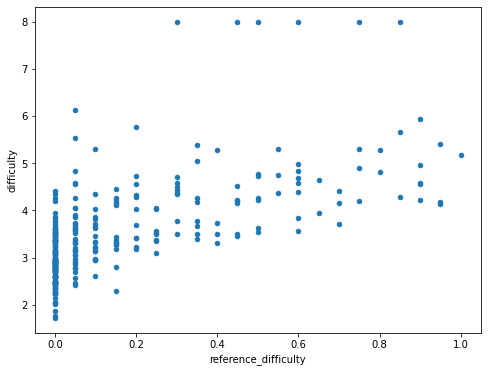

In [18]:
from utils.evaluation_utils.evaluation import get_difficulty_scatter

get_difficulty_scatter(df_res)

In [10]:
correlation

0.6446626359393217

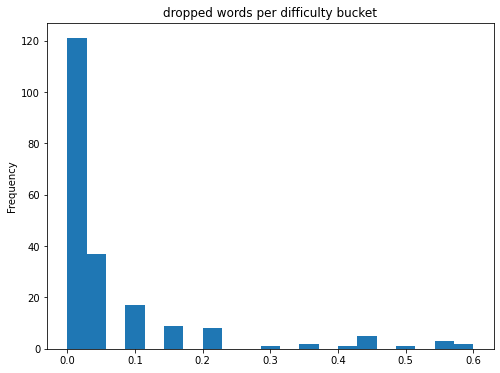

In [11]:
from utils.evaluation_utils.evaluation import get_dropped_histogram

get_dropped_histogram(df_res)

In [12]:
drop

0.02014492753623189